#
<FONT size="10pt"> <center>Projet 4 : SiteEUIWN(kBtu/sf)</center></FONT>. 

Vous travaillez pour la ville de **Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la **consommation et aux émissions des bâtiments non destinés à l’habitation.**

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les **émissions de CO2** et **la consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur **les données structurelles des bâtiments** (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

    - Réaliser une courte analyse exploratoire.
    - Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

**Livrables :**

    - Un notebook de l'analyse exploratoire mis au propre et annoté.
    - Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
    - Un support de présentation pour la soutenance (entre 15 et 25 slides).

# 1 : Librairies et Options

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import timeit
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
from simple_colors import *

import sklearn.metrics as metrics
from sklearn import dummy
from sklearn.linear_model import LinearRegression
from regressors import stats
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('mode.chained_assignment', None) # Pour ne pas avoir de message d'erreur quand on crée nouvelle df à partir d'une autre (app)

# 2 : Définitions pour les modèles de ML et le choix des Meilleurs Variables

## 2.1 : Définitions pour modèles naifs

In [2]:
def ModelRandom (X_test, X_train, y_test, y_train):
    
    start_time = timeit.default_timer()
    y = pd.concat([y_train,y_test]).sort_index()

    y_pred_random_test = np.random.randint(np.min(y), np.max(y), y_test.shape)
    y_pred_random_train = np.random.randint(np.min(y), np.max(y), y_train.shape)

    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_random_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_random_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_random_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_random_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3)

In [3]:
def ModelDum (X_test, X_train, y_test, y_train):
    
    start_time = timeit.default_timer()
    dum = dummy.DummyRegressor(strategy = 'mean')
    dum.fit(X_train, y_train)
    y_pred_dum_test = dum.predict(X_test)
    y_pred_dum_train = dum.predict(X_train)

    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_dum_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_dum_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_dum_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3)

## 2.2 : Définitions pour modèle Régression Linaire

In [4]:
def ModelLR (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()
    
    # Modèle simple
    modelLR = LinearRegression().fit(X_train, y_train)
    y_pred_LR_test = modelLR.predict(X_test)
    y_pred_LR_train = modelLR.predict(X_train)

    # Scores
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_LR_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_LR_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_LR_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_LR_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time
    
    # Récupération Coeff et Pvalue :
    try:
        PValue = stats.coef_pval(modelLR, X, y).round(3)
    except:
        PValue = np.zeros(len(X.columns))
    Columns = X.columns
    Coef = modelLR.coef_
    
    # Création de la Data Frame :
    DFLR = pd.DataFrame((zip(Columns, Coef, PValue)), columns = ['Variables', 'Coefficient', 'Pvalue'])
    DFLR = DFLR[DFLR['Pvalue'] <= 0.05]
    DFLR['Coefficient'] = DFLR['Coefficient'].round(3)
    DFLR = DFLR.sort_values('Coefficient', ascending = False)    

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), DFLR

## 2.3 : Définitions pour modèles RL avec régularisation via Ridge, Lasso et ElasticNet

### 2.3.1 : Ridge

In [5]:
def ModelRidge (X_test, X_train, y_test, y_train) :
    
    start_time = timeit.default_timer()
    
    # Modèle simple :
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    modelRid = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv = SKF).fit(X_train, y_train)

    y_pred_RI_test = modelRid.predict(X_test)
    y_pred_RI_train = modelRid.predict(X_train)

    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_RI_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_RI_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_RI_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_RI_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time

    # Récupération Coeff et Pvalue :
    try:
        PValue = stats.coef_pval(modelRid, X, y).round(3)
    except:
        PValue = np.zeros(len(X.columns))
    Coef = modelRid.coef_
    Columns = X.columns

    dfRid = pd.DataFrame((zip(Columns, Coef, PValue)), columns = ['Variables', 'Coefficient', 'PValue'])
    dfRid['Coefficient'] = dfRid['Coefficient'].round(3)
    dfRid = dfRid[dfRid['Coefficient'] != 0].sort_values('Coefficient', ascending = False)
    dfRid = dfRid[dfRid['PValue'] <= 0.05]
    
    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dfRid

### 2.3.2 : Lasso

In [6]:
def ModelLasso (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()
    
    # Modèle simple :
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    modelLasso = LassoCV(alphas=np.logspace(-1, 2, 20), cv = SKF, random_state = 42).fit(X_train, y_train)

    y_pred_LA_test = modelLasso.predict(X_test)
    y_pred_LA_train = modelLasso.predict(X_train)

    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_LA_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_LA_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_LA_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_LA_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time
    
    # Récupération Coeff et Pvalue :
    try :
        PValue = stats.coef_pval(modelLasso, X, y).round(3)
    except:
        PValue = np.zeros(len(X.columns))
    Coef = modelLasso.coef_
    Columns = X.columns

    dflasso = pd.DataFrame((zip(Columns, Coef, PValue)), columns = ['Variables', 'Coefficient', 'PValue'])
    dflasso['Coefficient'] = dflasso['Coefficient'].round(3)
    dflasso = dflasso[dflasso['Coefficient'] != 0].sort_values('Coefficient', ascending = False)
    dflasso = dflasso[dflasso['PValue'] <= 0.05]
    
    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dflasso

### 2.3.3 : Elastine Net

In [7]:
def ModelEN (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()

    # Modèle Simple :
    alphas = np.logspace(-1, 2, 20)
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)

    modelEN = ElasticNetCV(alphas=alphas, cv=SKF).fit(X_train, y_train)
    y_pred_EN_test = modelEN.predict(X_test)
    y_pred_EN_train = modelEN.predict(X_train)

    # Calculs :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_EN_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_EN_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_EN_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_EN_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time
    
    # Récupération Coeff et Pvalue :
    try:
        PValue = stats.coef_pval(modelEN, X, y).round(3)
    except:
        PValue = np.zeros(len(X.columns))
    CoefEN = modelEN.coef_
    Columns = X.columns

    dfEN = pd.DataFrame((zip(Columns, CoefEN, PValue)), columns = ['Variables', 'Coefficient', 'PValue'])
    dfEN['Coefficient'] = dfEN['Coefficient'].round(3)
    dfEN = dfEN[dfEN['Coefficient'] != 0].sort_values('Coefficient', ascending = False)
    dfEN = dfEN[dfEN['PValue'] <= 0.05]
    
    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dfEN

## 2.4 : Définition pour le modèle arbre de décision

**Hyperparamètres** :
- **max_depth** = profondeur maximale de l’arbre.
- **min_samples_leaf** = donne le nombre minimal d’échantillons dans un nœud feuille.

In [8]:
def ModelDT (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()

    # Modèle Simple :
    dico = {'max_depth' : range(2,5), "min_samples_leaf" : [5, 10, 15, 20]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    
    modelDT = GridSearchCV(DecisionTreeRegressor(random_state = 42), dico, cv = SKF, refit=True).fit(X_train, y_train)
    BestMD = modelDT.best_params_['max_depth']
    BestMSL = modelDT.best_params_['min_samples_leaf']
    y_pred_DT_test = modelDT.predict(X_test)
    y_pred_DT_train = modelDT.predict(X_train)

    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_DT_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_DT_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_DT_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_DT_train).round(4)
    DifRsquare = Rsquaretrain - Rsquaretest
    elapsed = timeit.default_timer() - start_time
    
    # Récupération des Feature Importances :
    modelDT2 = DecisionTreeRegressor(random_state = 42, min_samples_leaf = BestMSL, max_depth = BestMD).fit(X_train, y_train)
    DTIF = modelDT2.feature_importances_
    Columns = X.columns

    dfDTIF = pd.DataFrame((zip(Columns, DTIF)), columns = ['Variables', 'BestFeature'])
    dfDTIF = dfDTIF.sort_values('BestFeature', ascending = False)
    dfDTIF['BestFeature'] = dfDTIF['BestFeature'].round(4)
    dfDTIF = dfDTIF[dfDTIF['BestFeature'] > 0]
    
    # Récupération des Permutation Importance :
    modelDT3 = permutation_importance(modelDT, X_test, y_test, n_repeats=30, random_state=42)
    forest_importances = pd.Series(modelDT3.importances_mean, index = X_test.columns).sort_values(ascending = False)
    forest_importances = forest_importances[forest_importances.round(4) > 0]
    forest_importances = forest_importances.to_frame().reset_index().rename(columns = {'index':'Variables', 0:'BestPermut'})
     
    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dfDTIF, forest_importances

## 2.5 : Définition pour le modèle KNN

In [9]:
def ModelKNN (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()

    dico = {'n_neighbors' : range(2,50), 'weights' : ['uniform', 'distance']}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)

    modelKNN = GridSearchCV(KNeighborsRegressor(), dico, cv = SKF, refit=True).fit(X_train, y_train)

    y_pred_KNN_test = modelKNN.predict(X_test)
    y_pred_KNN_train = modelKNN.predict(X_train)

    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNN_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_KNN_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_KNN_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_KNN_train).round(4)
    elapsed = timeit.default_timer() - start_time
    DifRsquare = Rsquaretrain - Rsquaretest

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3) 

## 2.6 : Définitions pour le modèle Random Forest

**Hyperparamètres** :
- **max_depth** = profondeur maximale de l’arbre.
- **n_estimator** = il s’agit du nombre d’arbres dans la forêt.
- **max_features** = il s’agit du nombre de colonnes sélectionnées pour chaque arbre.
- **max_samples** = si vous voulez réduire le nombre d’observations dans vos échantillons bootstrap.
- **min_samples_split** = il s’agit du nombre d’échantillons minimal dans une feuille pour refaire une séparation.
- **min_samples_leaf** = il s’agit du nombre d’échantillons minimal pour créer une feuille 

In [10]:
def ModelRF (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()

    # Modèle Simple :
    dico = {'max_depth' : range(3,6), 'n_estimators' : [300,400,500], 'min_samples_leaf': [4, 5, 6]}
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)

    modelRF = GridSearchCV(RandomForestRegressor(random_state = 42), dico, cv = SKF , refit=True).fit(X_train, y_train)
    BestMD = modelRF.best_params_['max_depth']
    BestEstimators = modelRF.best_params_['n_estimators']
    BestMSL = modelRF.best_params_['min_samples_leaf']
    y_pred_RF_test = modelRF.predict(X_test)
    y_pred_RF_train = modelRF.predict(X_train)

    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_RF_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_RF_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_RF_train).round(4)
    elapsed = timeit.default_timer() - start_time
    DifRsquare = Rsquaretrain - Rsquaretest
    
    # Récupération des Features Importances :
    modelRFFI = RandomForestRegressor(max_depth = BestMD, n_estimators = BestEstimators, min_samples_leaf = BestMSL, random_state = 42).fit(X_train, y_train)
    RFFI = modelRFFI.feature_importances_
    Columns = X.columns

    dfRFFI = pd.DataFrame((zip(Columns, RFFI)), columns = ['Variables', 'BestFeature'])
    dfRFFI = dfRFFI.sort_values('BestFeature', ascending = False)
    dfRFFI['BestFeature'] = dfRFFI['BestFeature'].round(2)
    dfRFFI = dfRFFI[dfRFFI['BestFeature'] > 0]

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dfRFFI

## 2.7 : Définitions pour le modèle XGBoost

**Hyperparamètres** :
- **max_depth** = profondeur maximale de l’arbre.
- **n_estimator** = il s’agit du nombre d’arbres dans la forêt.
- **learning_rate** = taux d'apprentissage.
- **subsample** = ratio de sous-échantillon de l'instance d'entraînement.
- **reg_alpha** = Régularisation L1 sur les poids.
- **reg_lambda** = Régularisation L2 sur les poids.
- **colsample_bytree** = Ratio de sous-échantillonnage pour les colonnes utilisées, pour chaque arbre. Cela signifie que pour chaque arbre, une sous-sélection des caractéristiques sera choisie au hasard. Cet hyperparamètre détermine la part des caractéristiques choisies au hasard pour chaque arbre.
- **gamma** = hyperparamètre de pseudo-régularisation dans le gradient boosting.
- **min_child_weight** = somme minimale de poids d'instance (hesse) nécessaire chez un enfant.

**Definitions des features importance paramétre :**
- **Weight** : Le nombre de fois qu'une variable est utilisée pour répartir les données sur tous les arbres.
- **Cover** : Le nombre de fois qu'une variable est utilisée pour diviser les données sur tous les arbres pondérés par le nombre de points de données d'apprentissage qui passent par ces divisions.
- **Gain** : La réduction moyenne de la perte d'entraînement obtenue lors de l'utilisation d'une variable pour le fractionnement.

In [11]:
def ModelXGB (X_test, X_train, y_test, y_train) :

    start_time = timeit.default_timer()
    
    # Modèle XGB :

    # Step 1: Fix the learning rate and number of estimators for tuning tree-based parameters.
    modelXGB1 = XGBRegressor(n_jobs = -1, random_state = 42, learning_rate =0.1, n_estimators=1000, max_depth=5, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=20).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose = False)
    BestEstimator = modelXGB1.best_ntree_limit

    # Step 2: Tune max_depth and min_child_weight.
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    dico1 = {'max_depth':range(3,10,1), 'min_child_weight':range(1,10,1)}
    modelXGB2 = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 42, learning_rate = 0.1, n_estimators = BestEstimator, subsample=0.8, colsample_bytree=0.8 ), dico1, cv = SKF, refit=True).fit(X_train, y_train)
    BestDepth = modelXGB2.best_params_['max_depth']
    Bestminchildweight = modelXGB2.best_params_['min_child_weight']

    # Step 3: Tune gamma.
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    dico2 = {'gamma':range(1,10,1)}
    modelXGB3 = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 42, learning_rate = 0.1, n_estimators = BestEstimator, subsample=0.8, max_depth = BestDepth, min_child_weight = Bestminchildweight, colsample_bytree=0.8), dico2, cv = SKF, refit=True).fit(X_train, y_train)
    BestGamma = modelXGB3.best_params_['gamma']

    # Step 4: New n_estimators with this params.
    modelXGB4 = XGBRegressor(n_jobs = -1, random_state = 42, learning_rate = 0.1, subsample=0.8, max_depth = BestDepth, min_child_weight = Bestminchildweight, colsample_bytree=0.8, gamma = BestGamma, early_stopping_rounds=20).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose = False)
    BestEstimator = modelXGB4.best_ntree_limit

    # Step 5: Tune subsample and colsample_bytree.
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    dico3 = {'subsample':np.arange(0.5,1,0.05), 'colsample_bytree':np.arange(0.5,1,0.05)}
    modelXGB5 = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 42, learning_rate = 0.1, n_estimators = BestEstimator, max_depth = BestDepth, min_child_weight = Bestminchildweight, gamma = BestGamma), dico3, cv = SKF, refit=True).fit(X_train, y_train)
    Bestsub = modelXGB5.best_params_['subsample']
    Bestcoltree = modelXGB5.best_params_['colsample_bytree']

    # Step 6: Tuning regularization parameters.
    SKF = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42).split(X_train, y_train2)
    dico4 = {'reg_alpha':np.arange(0.5, 1, 0.1), 'reg_lambda': range(0,10,1)}
    modelXGB6 = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 42, learning_rate = 0.1, n_estimators = BestEstimator, max_depth = BestDepth, min_child_weight = Bestminchildweight, gamma = BestGamma, subsample = Bestsub, colsample_bytree = Bestcoltree), dico4, cv = SKF, refit=True).fit(X_train, y_train)
    Bestregalpha = modelXGB6.best_params_['reg_alpha']
    Bestreglambda = modelXGB6.best_params_['reg_lambda']

    # Step 7: Reducing the learning rate.
    modelXGB7 = XGBRegressor(n_jobs = -1, n_estimators = 5000, reg_alpha = Bestregalpha, reg_lambda = Bestreglambda, random_state = 42, learning_rate = 0.01, max_depth = BestDepth, min_child_weight = Bestminchildweight, gamma = BestGamma, subsample = Bestsub, colsample_bytree = Bestcoltree, early_stopping_rounds=20).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose = False)

    y_pred_XGB_test = modelXGB7.predict(X_test)
    y_pred_XGB_train = modelXGB7.predict(X_train)

    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGB_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_XGB_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_XGB_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_XGB_train).round(4)
    elapsed = timeit.default_timer() - start_time
    DifRsquare = Rsquaretrain - Rsquaretest
    
    # Analyse de l'importance des features :
    Weight = modelXGB7.get_booster().get_score(importance_type='weight')
    Gain = modelXGB7.get_booster().get_score(importance_type='gain')
    Cover = modelXGB7.get_booster().get_score(importance_type='cover')

    Weight2 = pd.DataFrame(Weight.items(), columns=['Variables', 'ValuesWeight']).sort_values('ValuesWeight', ascending = False).set_index('Variables')
    Gain2 = pd.DataFrame(Gain.items(), columns=['Variables', 'ValuesGain']).sort_values('ValuesGain', ascending = False).set_index('Variables')
    Cover2 = pd.DataFrame(Cover.items(), columns=['Variables', 'ValuesCover']).sort_values('ValuesCover', ascending = False).set_index('Variables')
    
    dfWGC = pd.merge(Weight2, Gain2, how = 'outer', right_index = True, left_index = True)
    dfWGC = pd.merge(dfWGC, Cover2, how = 'outer', right_index = True, left_index = True)
    
    for Col in dfWGC.columns :
        scaler = MinMaxScaler().fit(dfWGC[[Col]])
        dfWGC[Col] = scaler.transform(dfWGC[[Col]])
    
    # Création d'un score avec les 3 paramètres pour simplifier l'analyse :
    dfWGC['Score'] = dfWGC['ValuesWeight'] + dfWGC['ValuesCover'] + (1+dfWGC['ValuesGain'])
    dfWGC = dfWGC.sort_values('Score', ascending = False)
    del dfWGC['ValuesWeight']
    del dfWGC['ValuesCover']
    del dfWGC['ValuesGain']
    dfWGC.reset_index(inplace = True)

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), dfWGC 

## 2.8 : Définition pour le modèle SVM

In [12]:
def ModelSVM (X_test, X_train, y_test, y_train) :
    start_time = timeit.default_timer()
    
    # Modèle simple :
    C_range = np.logspace(-2, 5, 6)
    gamma_range = np.logspace(-4, 1, 4)
    dico = {'C': C_range, 'gamma': gamma_range}

    modelSVM = GridSearchCV(svm.SVR(), dico, cv = 3, refit=True).fit(X_train, y_train)
    y_pred_SVM_test = modelSVM.predict(X_test)
    y_pred_SVM_train = modelSVM.predict(X_train)
    
    # Mesures :
    RMSEtest = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_SVM_test)),2)
    RMSEtrain = round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_SVM_train)),2)
    Rsquaretest = metrics.r2_score(y_test, y_pred_SVM_test).round(4)
    Rsquaretrain = metrics.r2_score(y_train, y_pred_SVM_train).round(4)
    elapsed = timeit.default_timer() - start_time
    DifRsquare = Rsquaretrain - Rsquaretest
    
    # Récupération des Permutation Importance :
    modelSVM2 = permutation_importance(modelSVM, X_test, y_test, n_repeats=30, random_state=42)
    forest_importances = pd.Series(modelSVM2.importances_mean, index = X_test.columns).sort_values(ascending = False)
    forest_importances = forest_importances[forest_importances.round(4) > 0]
    forest_importances = forest_importances.to_frame().reset_index().rename(columns = {'index':'Variables', 0:'BestPermut'})
    forest_importances

    return RMSEtest.round(3), RMSEtrain.round(3), Rsquaretest.round(3), Rsquaretrain.round(3), DifRsquare.round(3), round(elapsed,3), forest_importances 

## 2.9 : Définition pour obtenir les résultats de ML avec toutes les variables

In [13]:
def ModelSimple (X_test, X_train, y_test, y_train) :

    Models = [ModelLR, ModelRidge, ModelLasso, ModelEN, ModelDT, ModelKNN, ModelRF, ModelXGB, ModelSVM]

    start_time = timeit.default_timer()

    dfComparaisonMS = pd.DataFrame()
    BestVariables = []

    for model in Models :
        resultats = model(X_test, X_train, y_test, y_train)
        resultat = resultats[:6]
        Frame = pd.DataFrame(resultat).T
        Frame.columns = ['RMSEtest', 'RMSETrain','R²Test', 'R²train', 'DiffR²', 'RunTime']
        Frame.insert(0, 'Model', str(model).split(' ')[1])
        dfComparaisonMS = pd.concat([dfComparaisonMS, Frame])
        try : 
            BestVariables.append(list(resultats[6:7])[0])
        except :
            BestVariables.append(pd.DataFrame())

    print('Il a fallut {} secondes pour runner tous les modèles de ML.'.format(round(timeit.default_timer() - start_time),1))
    print()
    ResultatsSimples = dfComparaisonMS.sort_values('R²Test', ascending = False)
    return ResultatsSimples, BestVariables

## 2.10 : Définition pour obtenir une visualisation des variables pertinantes de chaque model (fonctionne avec la 2.9)

In [14]:
def VisualBestParams (Simples) :

    Variables = []
    ListesVariables = ['LR', 'Ridge', 'Lasso', 'EN',  'DT', 'KNN', 'RF', 'XG', 'SVM']
    Emplacements = [331,332,333,334,335,336,337,338,339]
    DF = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    plt.subplots(3,3,figsize = (20,12))
    
    #for DF, Listes, Emplacement in zip (ListesDF, ListesVariables, Emplacements):
    for data, place, LV in zip(DF, Emplacements, ListesVariables):
        try :
            df = Simples[data]
            df['Absolute'] = abs(df.iloc[:,1:2].squeeze())
            df = df.sort_values('Absolute', ascending = False)
            plt.subplot(place)
            sns.barplot(y = df.iloc[:,:1].squeeze().head(10), x = df.iloc[:,1:2].squeeze().head(10))
            plt.suptitle('Visualisation des variables pertinantes issus des modèles :', size = 15)
            plt.title(LV)
            plt.ylabel(df.iloc[:,1:2].columns[0], size = 10)
            Variables.append(df['Variables'].values)
            plt.subplots_adjust(wspace=0.8, hspace=0.4)
        except : # Le modèle KNN n'ayant pas de feature importance
            Variables.append(X.columns)
    
    return Variables

## 2.11 : Définition pour obtenir les résultats de ML avec les variables les plus pertinantes (fonctionne avec la 2.9)

In [15]:
def BestVariables (VariablesGardees) :
    ListesVariables = VariablesGardees
    Models = [ModelLR, ModelRidge, ModelLasso, ModelEN, ModelDT, ModelKNN, ModelRF, ModelXGB, ModelSVM]

    start_time = timeit.default_timer()
    dfComparaisonMBV = pd.DataFrame()

    for Variables, model in zip (ListesVariables, Models) :
        X_test2 = X_test[Variables]
        X_train2 = X_train[Variables]

        resultats = model(X_test2, X_train2, y_test, y_train)[:6]
        Frame = pd.DataFrame(resultats).T
        Frame.columns = ['RMSEtest', 'RMSETrain','R²Test', 'R²train', 'DiffR²', 'RunTime']
        Frame.insert(0, 'Model', str(model).split(' ')[1])
        dfComparaisonMBV = pd.concat([dfComparaisonMBV, Frame])

    print('Il a fallut {} secondes pour runner tous les modèles de ML.'.format(round(timeit.default_timer() - start_time),1))
    print()
    ResultatsBestvariables = dfComparaisonMBV.sort_values('R²Test', ascending = False)
    return ResultatsBestvariables

## 2.12 : Definition pour obtenir les résultats de ML avec le variables les plus pertiantes du modèle Elastic net (fonctionne avec la 2.9)

In [16]:
def BestVariablesEN (VariablesGardees) :

    Variables = VariablesGardees[3:4]
    Models = [ModelLR, ModelRidge, ModelLasso, ModelEN, ModelDT, ModelKNN, ModelRF, ModelXGB, ModelSVM]

    start_time = timeit.default_timer()
    dfComparaisonMBV = pd.DataFrame()

    for model in Models :
        X_test2 = X_test[Variables[0]]
        X_train2 = X_train[Variables[0]]

        resultats = model(X_test2, X_train2, y_test, y_train)[:6]
        Frame = pd.DataFrame(resultats).T
        Frame.columns = ['RMSEtest', 'RMSETrain','R²Test', 'R²train', 'DiffR²', 'RunTime']
        Frame.insert(0, 'Model', str(model).split(' ')[1])
        dfComparaisonMBV = pd.concat([dfComparaisonMBV, Frame])

    print('Il a fallut {} secondes pour runner tous les modèles de ML.'.format(round(timeit.default_timer() - start_time),1))
    print()
    ResultatsBestEN = dfComparaisonMBV.sort_values('R²Test', ascending = False)
    return ResultatsBestEN

# 3 : Etude en ML des données sans le NRJ Star Score

## 3.1 : Ouverture du fichier

In [17]:
Data = pd.read_csv('DonneesP4nettoyees')

## 3.2 : Transformation des colonnes

In [18]:
# Création d'une DF parallèle :
DataFinal = Data.copy()

# Création des colonnes pourcentage d'énergie utilisée :
DataFinal['SteamUse(kBtu/sf)'] = (DataFinal['SteamUse(kBtu/sf)'] / (DataFinal[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)
DataFinal['Electricity(kBtu/sf)'] = (DataFinal['Electricity(kBtu/sf)'] / (DataFinal[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)
DataFinal['NaturalGas(kBtu/sf)'] = (DataFinal['NaturalGas(kBtu/sf)'] / (DataFinal[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)

DataFinal.rename(columns = {'SteamUse(kBtu/sf)': 'SteamUse(%)', 'Electricity(kBtu/sf)' : 'Electricity(%)', 'NaturalGas(kBtu/sf)' : 'NaturalGas(%)' }, inplace = True)

# Suppression colonnes en trop ou redondantes :
del DataFinal['CouncilDistrictCode'] # redondant avec les quartiers.
del DataFinal['YearBuilt'] # redondant avec les années par décénies.
del DataFinal['PropertyGFABuilding(s)'] # redondante avec les variables par batiments.

# Recherche des variables qualitatives :
print('Les variables qualitatives à transformer sont :', ', '.join(DataFinal.select_dtypes(include = 'object').columns.values))
print()

# Cardinalité des variables catégorielles :
print('La variable Building Type à', DataFinal['BuildingType'].nunique(),'valeurs différentes.')
print('La variable Quartier à', DataFinal['Neighborhood'].nunique(),'valeurs différentes.')
print('La variable PrimaryPropertyType à', DataFinal['PrimaryPropertyType'].nunique(),'valeurs différentes.')

# Dummisation :
DataFinal = pd.concat([DataFinal , DataFinal['BuildingType'].str.get_dummies()], axis = 1)
DataFinal = pd.concat([DataFinal , DataFinal['Neighborhood'].str.get_dummies()], axis = 1)
DataFinal = pd.concat([DataFinal , DataFinal['PrimaryPropertyType'].str.get_dummies()], axis = 1)

# Target Encoder :
encoder = TargetEncoder()
#DataFinal['Neighborhood'] = encoder.fit_transform(DataFinal['Neighborhood'], DataFinal['SiteEUIWN(kBtu/sf)'])
#DataFinal['PrimaryPropertyType'] = encoder.fit_transform(DataFinal['PrimaryPropertyType'], DataFinal['SiteEUIWN(kBtu/sf)'])
#DataFinal['BuildingType'] = encoder.fit_transform(DataFinal['BuildingType'], DataFinal['SiteEUIWN(kBtu/sf)'])

Les variables qualitatives à transformer sont : BuildingType, PrimaryPropertyType, Neighborhood

La variable Building Type à 5 valeurs différentes.
La variable Quartier à 13 valeurs différentes.
La variable PrimaryPropertyType à 19 valeurs différentes.


## 3.3 : Créations du Train et du Test

In [19]:
# Création des X et y :
y = DataFinal['SiteEUIWN(kBtu/sf)']

DataFinal = DataFinal.drop(columns = ['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity','ENERGYSTARScore'])

X = DataFinal.select_dtypes(exclude = 'object')

In [20]:
# Catégorisation de y pour la stratification :
y_categ = pd.qcut(y.to_list(), 30)
dfy = pd.DataFrame(y_categ)

In [21]:
# Split des données :
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y_categ)

In [22]:
# Vérification de la répartition des données suite au stratify :
print('Valeurs y du test : ')
print(dfy.drop(index = (y_train.index)).value_counts())
print(len(dfy.drop(index = (y_train.index)).value_counts()))
print()
print('Valeurs y du train : ')
print(dfy.drop(index = (y_test.index)).value_counts())
print(len(dfy.drop(index = (y_test.index)).value_counts()))

Valeurs y du test : 
(51.21, 53.5]       16
(1.499, 10.27]      15
(10.27, 16.54]      15
(177.98, 229.3]     15
(140.29, 177.98]    15
(118.62, 140.29]    15
(105.8, 118.62]     15
(96.16, 105.8]      15
(88.91, 96.16]      15
(83.28, 88.91]      15
(77.91, 83.28]      15
(73.8, 77.91]       15
(69.63, 73.8]       15
(65.96, 69.63]      15
(62.29, 65.96]      15
(55.9, 58.9]        15
(46.1, 48.1]        15
(43.8, 46.1]        15
(41.16, 43.8]       15
(38.1, 41.16]       15
(35.88, 38.1]       15
(33.14, 35.88]      15
(29.2, 33.14]       15
(24.96, 29.2]       15
(20.71, 24.96]      15
(16.54, 20.71]      15
(229.3, 385.6]      15
(58.9, 62.29]       14
(53.5, 55.9]        14
(48.1, 51.21]       14
dtype: int64
30

Valeurs y du train : 
(51.21, 53.5]       37
(24.96, 29.2]       36
(35.88, 38.1]       36
(41.16, 43.8]       36
(1.499, 10.27]      35
(10.27, 16.54]      35
(177.98, 229.3]     35
(140.29, 177.98]    35
(105.8, 118.62]     35
(96.16, 105.8]      35
(83.28, 88.91]      

In [23]:
# Création d'un y_train2 pour faire du Stratified K_Fold :
y_train2 = pd.qcut(y_train.to_list(), 30).codes

## 3.4 : Résultats sur les données

Il a fallut 631 secondes pour runner tous les modèles de ML.

Résultats sur les différents modèles avec toutes les variables : 

        Model  RMSEtest  RMSETrain  R²Test  R²train  DiffR²  RunTime
0    ModelXGB     30.83      16.22   0.718    0.921   0.203  209.471
0    ModelSVM     33.25      24.46   0.671    0.819   0.148   29.053
0  ModelLasso     35.55      29.97   0.624    0.729   0.104    0.079
0     ModelEN     35.64      30.67   0.622    0.716   0.093    0.067
0  ModelRidge     35.84      29.58   0.618    0.736   0.118    0.220
0     ModelLR     36.17      29.47   0.611    0.738   0.127    0.041
0     ModelRF     39.25      31.72   0.542    0.696   0.154  142.157
0    ModelKNN     41.10       0.00   0.498    1.000   0.502    6.751
0     ModelDT     43.58      36.62   0.436    0.595   0.159    0.787

Il a fallut 707 secondes pour runner tous les modèles de ML.

Résultats sur les différents modèles avec les variables importantes de chaques modèles : 

        Model  RMSEtest  RM

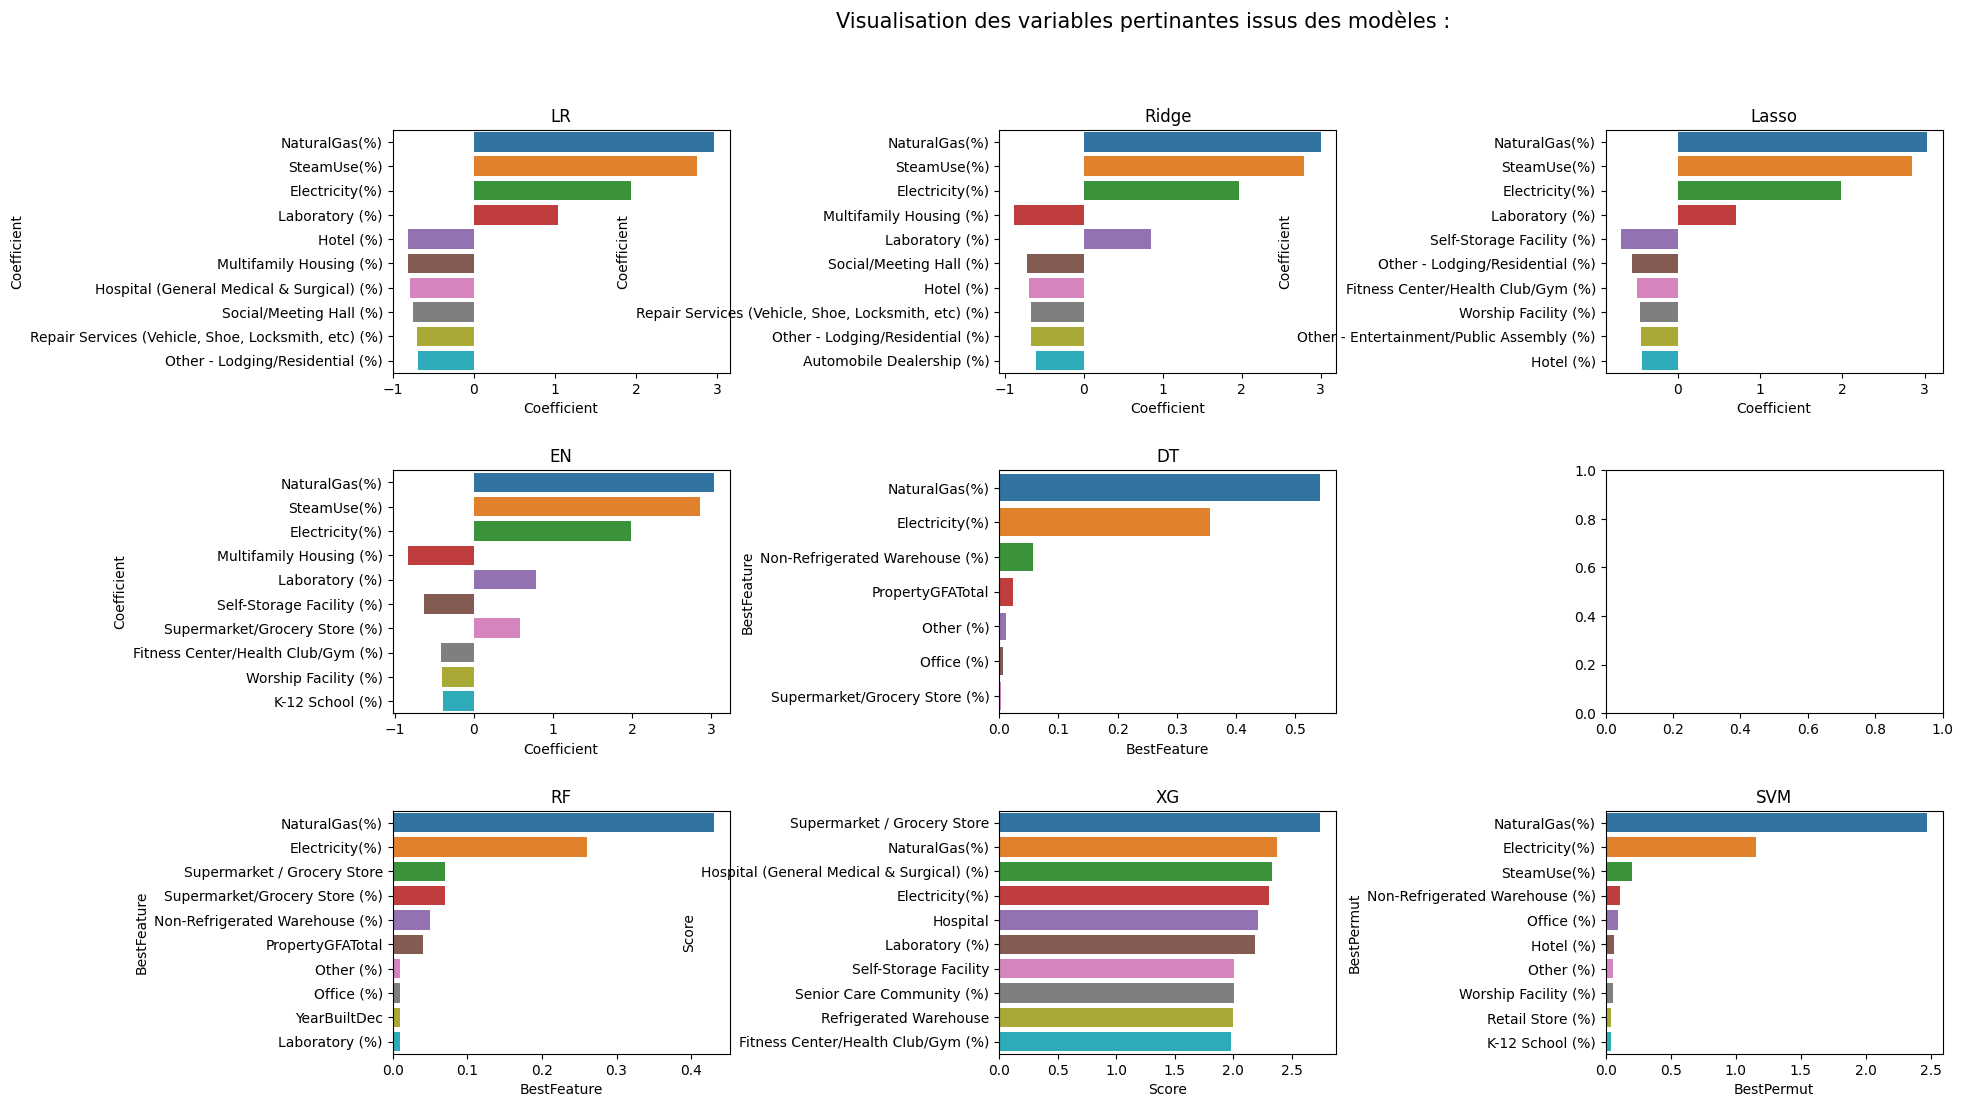

In [24]:
Simples = ModelSimple(X_test, X_train, y_test, y_train)
print(black('Résultats sur les différents modèles avec toutes les variables : ', 'bold'))
print()
print(Simples[0])
print()
VariablesGardees = VisualBestParams(Simples[1])
ResultatsBestVariables = BestVariables (VariablesGardees)
print(black('Résultats sur les différents modèles avec les variables importantes de chaques modèles : ', 'bold'))
print()
print(ResultatsBestVariables)
print()
ResultatsBestVariablesEN = BestVariablesEN (VariablesGardees)
print(black('Résultats sur les différents modèles avec les variables importantes du modèle Elastic Net : ', 'bold'))
print()
print(ResultatsBestVariablesEN)

# 4 : Résultats avec la variable NRJ Star Score en plus

## 4.1 : Transformation des variables

In [25]:
# Création d'une DF parallèle :
DataNRJ = Data.copy()
DataNRJ = DataNRJ.dropna()

# Création des colonnes pourcentage d'énergie utilisée :
DataNRJ['SteamUse(kBtu/sf)'] = (DataNRJ['SteamUse(kBtu/sf)'] / (DataNRJ[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)
DataNRJ['Electricity(kBtu/sf)'] = (DataNRJ['Electricity(kBtu/sf)'] / (DataNRJ[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)
DataNRJ['NaturalGas(kBtu/sf)'] = (DataNRJ['NaturalGas(kBtu/sf)'] / (DataNRJ[['SteamUse(kBtu/sf)', 'Electricity(kBtu/sf)', 'NaturalGas(kBtu/sf)']].sum(axis = 1))*100).astype(int)

DataNRJ.rename(columns = {'SteamUse(kBtu/sf)': 'SteamUse(%)', 'Electricity(kBtu/sf)' : 'Electricity(%)', 'NaturalGas(kBtu/sf)' : 'NaturalGas(%)' }, inplace = True)

# Suppression colonnes en trop ou redondantes :
del DataNRJ['CouncilDistrictCode'] # redondant avec les quartiers.
del DataNRJ['YearBuilt'] # redondant avec les années par décénies.
del DataNRJ['PropertyGFABuilding(s)'] # redondante avec les variables par batiments.

# Dummisation :
DataNRJ = pd.concat([DataNRJ , DataNRJ['BuildingType'].str.get_dummies()], axis = 1)
DataNRJ = pd.concat([DataNRJ , DataNRJ['Neighborhood'].str.get_dummies()], axis = 1)
DataNRJ = pd.concat([DataNRJ , DataNRJ['PrimaryPropertyType'].str.get_dummies()], axis = 1)

# Target Encoder :
encoder = TargetEncoder()
#DataNRJ['Neighborhood'] = encoder.fit_transform(DataNRJ['Neighborhood'], DataNRJ['SiteEUIWN(kBtu/sf)'])
#DataNRJ['PrimaryPropertyType'] = encoder.fit_transform(DataNRJ['PrimaryPropertyType'], DataNRJ['SiteEUIWN(kBtu/sf)'])
#DataNRJ['BuildingType'] = encoder.fit_transform(DataNRJ['BuildingType'], DataNRJ['SiteEUIWN(kBtu/sf)'])

## 4.2 : Création du Train et du Test

In [26]:
# Création des X et y :
y = DataNRJ['SiteEUIWN(kBtu/sf)']

DataNRJ = DataNRJ.drop(columns = ['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity'])

X = DataNRJ.select_dtypes(exclude = 'object')

# Catégorisation de y pour la stratification :
y_categ = pd.qcut(y.to_list(), 30)
dfy = pd.DataFrame(y_categ)

# Split des données :
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y_categ)

# Création d'un y_train2 pour faire du Stratified K_Fold :
y_train2 = pd.qcut(y_train.to_list(), 30).codes

## 4.3 : Résultats avec la variable NRJ Star Score

Il a fallut 423 secondes pour runner tous les modèles de ML.

Résultats sur les différents modèles avec toutes les variables : 

        Model  RMSEtest  RMSETrain  R²Test  R²train  DiffR²  RunTime
0    ModelSVM     20.58      17.02   0.851    0.900   0.049   20.307
0    ModelXGB     21.22       9.70   0.842    0.967   0.126  146.780
0  ModelRidge     24.23      23.10   0.793    0.815   0.022    0.177
0  ModelLasso     24.54      24.38   0.788    0.794   0.006    0.055
0     ModelLR     24.59      22.25   0.787    0.828   0.041    0.029
0     ModelEN     24.93      24.33   0.781    0.795   0.014    0.053
0     ModelRF     25.21      23.12   0.776    0.815   0.038  132.085
0    ModelKNN     26.43       0.00   0.754    1.000   0.246    5.162
0     ModelDT     31.95      29.94   0.641    0.689   0.049    0.387

Il a fallut 203 secondes pour runner tous les modèles de ML.

Résultats sur les différents modèles avec les variables importantes de chaques modèles : 

        Model  RMSEtest  RM

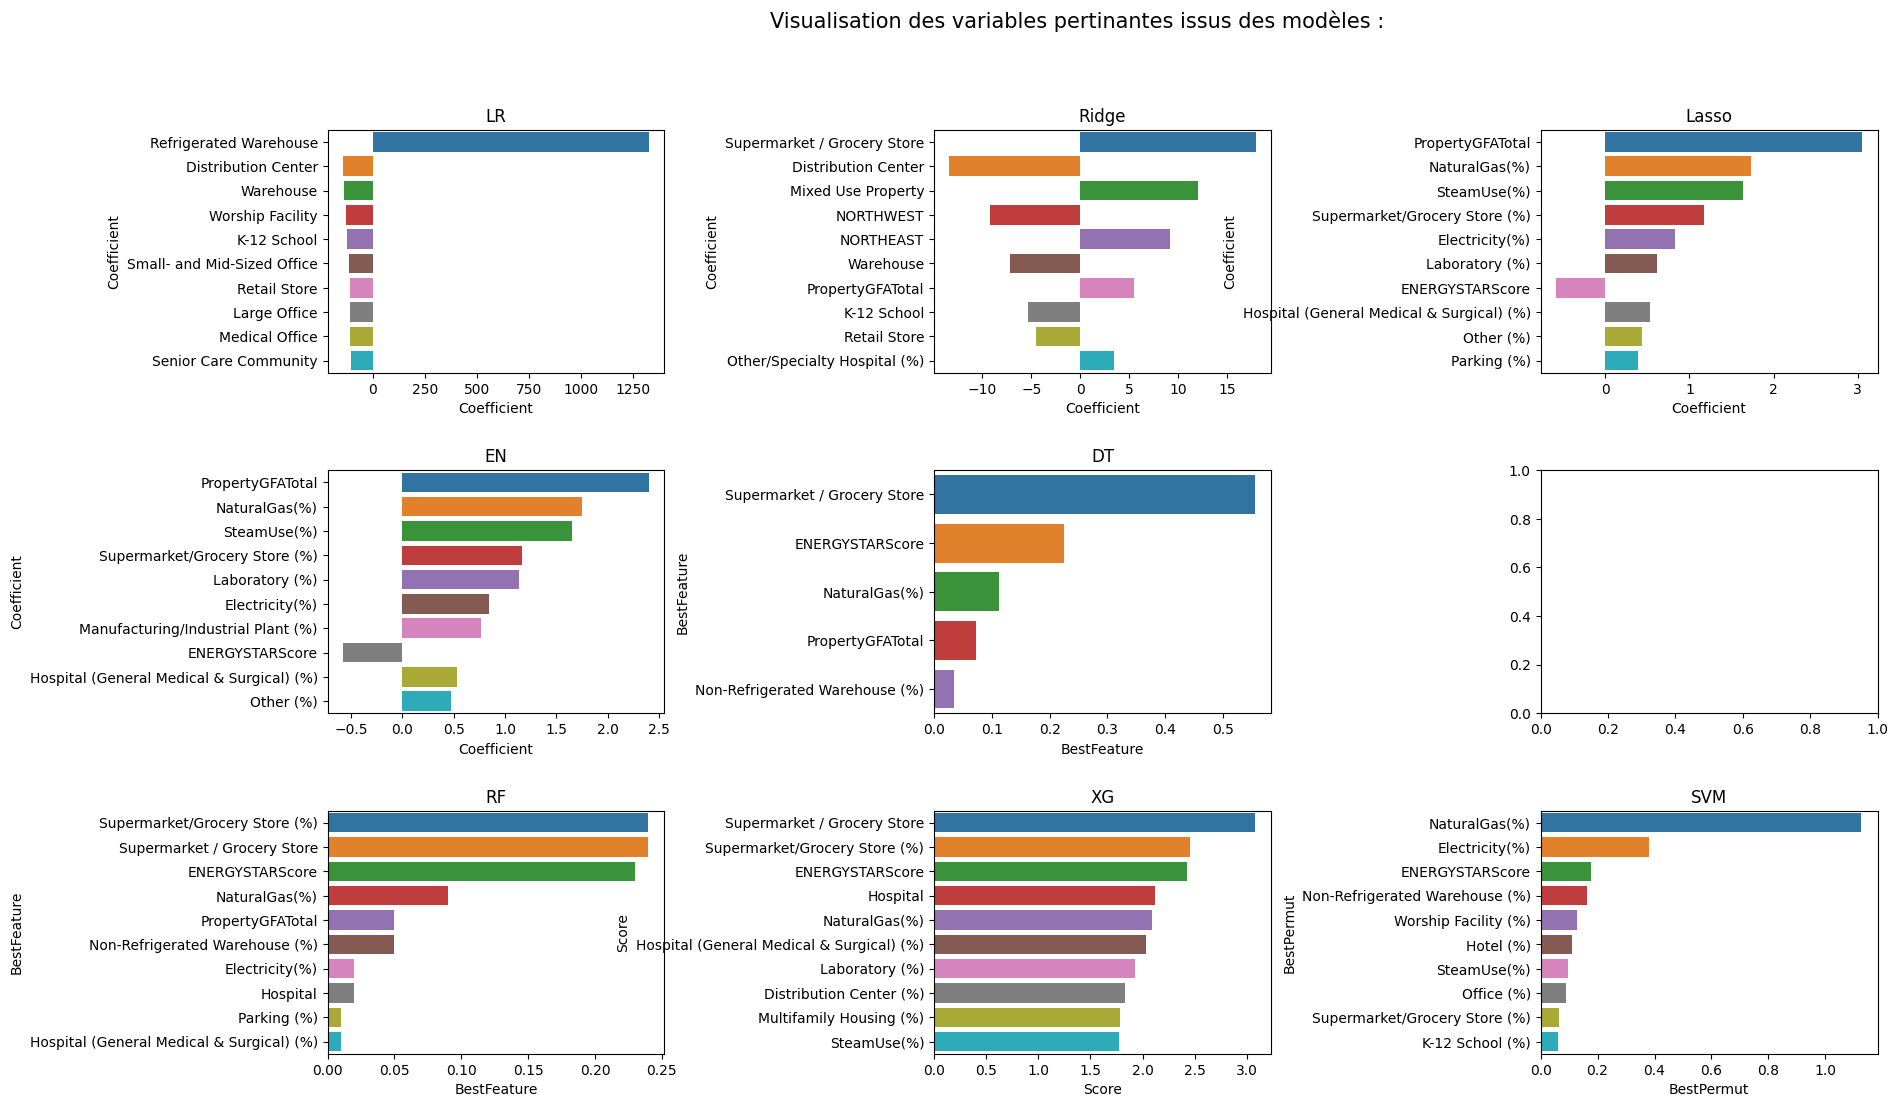

In [27]:
Simples = ModelSimple(X_test, X_train, y_test, y_train)
print(black('Résultats sur les différents modèles avec toutes les variables : ', 'bold'))
print()
print(Simples[0])
print()
VariablesGardees = VisualBestParams(Simples[1])
ResultatsBestVariables = BestVariables (VariablesGardees)
print(black('Résultats sur les différents modèles avec les variables importantes de chaques modèles : ', 'bold'))
print()
print(ResultatsBestVariables)
print()
ResultatsBestVariablesEN = BestVariablesEN (VariablesGardees)
print(black('Résultats sur les différents modèles avec les variables importantes du modèle Elastic Net : ', 'bold'))
print()
print(ResultatsBestVariablesEN)

# 5 : Approche théorique pour explication de modèles de ML (test sur RL)

## 5.1 : SHAP

In [36]:
import shap
shap.initjs()

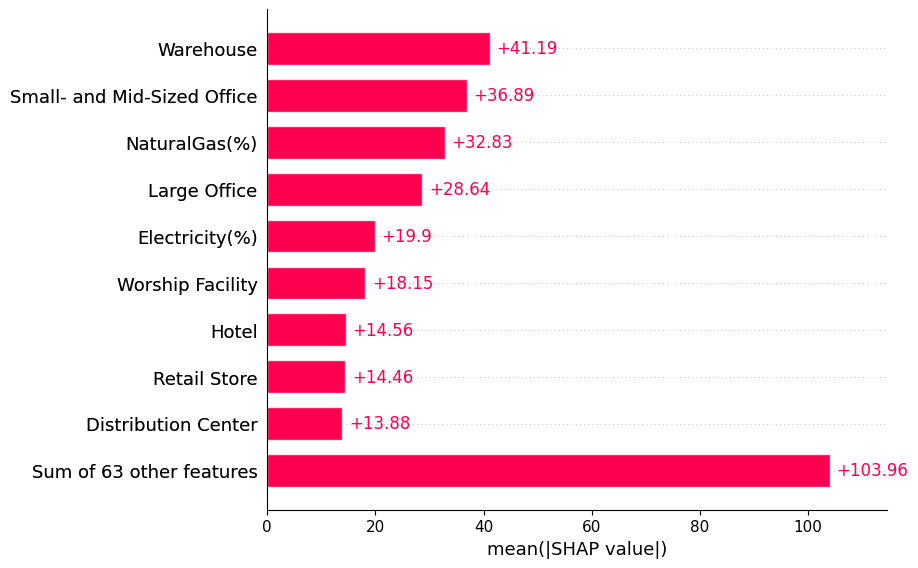

In [29]:
# Interprétation théorique globale :
modelLR = LinearRegression().fit(X_train, y_train)
explainer = shap.LinearExplainer(modelLR, X_train)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [30]:
shap.force_plot(shap_values, feature_names = X_test.columns)

In [31]:
# Autres visualisations globales

#shap.summary_plot(shap_values, X_test, max_display = 10)
#shap.plots.beeswarm(shap_values)
#shap.plots.heatmap(shap_values)

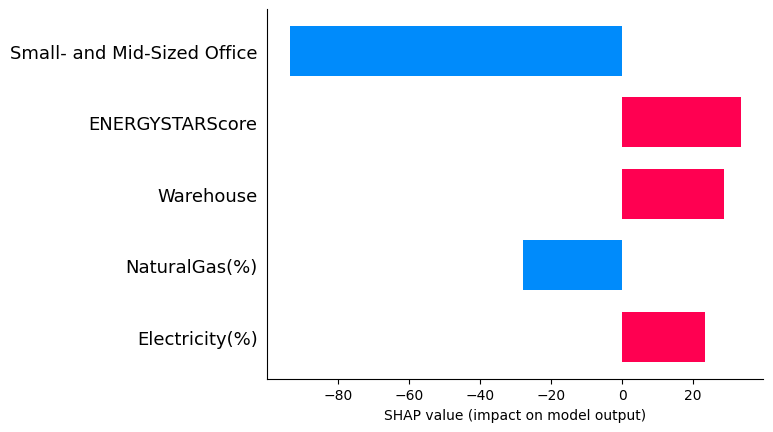

In [32]:
# Interprétation sur une seule ligne
shap.bar_plot(explainer.shap_values(X_test.values[0]),
              feature_names=X_test.columns,
              max_display = 5)

## 5.2 : LIME

In [33]:
from lime.lime_tabular import LimeTabularExplainer

In [34]:
modelLR = LinearRegression().fit(X_train.values, y_train)
explainer = LimeTabularExplainer(X_train.values, mode="regression", feature_names = X_train.columns)

In [35]:
# Interprétation théorique globale :
explanation = explainer.explain_instance(X_test.values[0], modelLR.predict)
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

NameError: name 'explanation' is not defined

In [ ]:
# Interprétation sur une seule ligne
explanation = explainer.explain_instance(X_test.values[0], modelLR.predict)
explanation.show_in_notebook()